<a href="https://colab.research.google.com/github/nnejere/IMDB-Movie-Review-Sentiment-Analysis-with-DistilBERT/blob/main/sentiment_analysis_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in COlab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1yiXQwKCwaAwnzeSl8GGfcmRLvTwqzCGP#scrollTo=xCgrNQu3gKvd)

# **IMDB MOVIE REVIEW SENTIMENT ANALYSIS Using Fine-Tuned DistilBERT**

# **Project Overview**

This project focuses on building a sentiment classification system capable of identifying whether a movie review expresses a positive or negative sentiment. Leveraging DistilBERT, a lightweight yet powerful transformer-based language model, the project applies transfer learning and fine-tuning to enhance model performance on the IMDB dataset.
The end goal is to create a deployable sentiment analysis application powered by a fine-tuned transformer model, which can interpret natural language text inputs in real time via a Streamlit interface and API endpoint.

# **Problem Statement**

Understanding human emotions and opinions expressed in text is a cornerstone of Natural Language Processing (NLP) and is crucial for applications like Customer feedback systems, Social media monitoring, Product review analysis and Automated moderation systems.
Traditional models rely heavily on manual feature extraction, but transformer architectures like BERT and DistilBERT revolutionized this by learning contextual meaning directly from data.

In this project, DistilBERT, a smaller and faster version of BERT — is fine-tuned on the IMDB movie review dataset to classify text into positive or negative sentiment.
The approach combines transfer learning (training only the classification head) and gradual unfreezing (fine-tuning deeper layers), ensuring a balance between performance and computational efficiency.  

Afterwhich creating a Streamlit and FastAPI Inference.

# **Objectives**

- Develop a sentiment classification model capable of accurately predicting the polarity (positive/negative) of movie reviews.

- Leverage the power of transformer-based models (DistilBERT) through transfer learning and fine-tuning for improved contextual understanding.

- Evaluate the model using accuracy, F1-score, precision, and recall to ensure balanced performance across both sentiment classes.

- Deploy the fine-tuned model using Streamlit for interactive user engagement and FastAPI for scalable inference.

- Demonstrate an end-to-end NLP workflow — from data exploration and preprocessing to model deployment.

# **Installations and Imports**

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import torch
from torch import nn, optim
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss

from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             precision_score,
                             recall_score,
                             classification_report
)
from google.colab import files
from tqdm.auto import tqdm
import shutil


# **Device Configuration(CPU/GPU)**  

Configures the computation device based on GPU availability.

In [ ]:
# Detect device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **Environment Configuration**  

Setting up configuration variables for the model, ensuring reproducibility and easy parameter modification.

In [ ]:

# Set Hyperparameters and Environment Variables

# Model setup
MODEL_NAME = "distilbert-base-uncased"
MAX_SEQ_LEN = 128   # Number of tokens per input sequence

# Training setup
BATCH_SIZE = 16     # Number of samples per training batch
EPOCHS_HEAD = 2     # Epochs for training only the classifier head
EPOCHS_FINE_TUNE = 3  # Epochs for full fine-tuning

# Learning rates
LR_HEAD = 1e-4      # For classifier head training (faster learning)
LR_FINE_TUNE = 5e-5 # For fine-tuning BERT layers (slower, more stable)

# Paths
MODEL_DIR = "fine_tuned_distilbert_imdb"
TOKENIZER_DIR = "fine_tuned_distilbert_imdb"

# HF_TOKEN = hugging face token is saved in notebook keys

print("Environment configuration loaded successfully.")


Environment configuration loaded successfully.


# **Load Tokenizer and Model**

In [ ]:

#  LOAD TOKENIZER AND MODEL


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load DistilBERT model with classification head (binary sentiment)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2  # IMDb is binary: positive/negative
)

# Move to GPU if available
model.to(device)

print("\nModel and tokenizer loaded successfully!")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model and tokenizer loaded successfully!


# **Inspecting Model's Layers**

In [ ]:
# View the model architecture
for name, param in model.named_parameters():
    print(name, param.requires_grad)


distilbert.embeddings.word_embeddings.weight True
distilbert.embeddings.position_embeddings.weight True
distilbert.embeddings.LayerNorm.weight True
distilbert.embeddings.LayerNorm.bias True
distilbert.transformer.layer.0.attention.q_lin.weight True
distilbert.transformer.layer.0.attention.q_lin.bias True
distilbert.transformer.layer.0.attention.k_lin.weight True
distilbert.transformer.layer.0.attention.k_lin.bias True
distilbert.transformer.layer.0.attention.v_lin.weight True
distilbert.transformer.layer.0.attention.v_lin.bias True
distilbert.transformer.layer.0.attention.out_lin.weight True
distilbert.transformer.layer.0.attention.out_lin.bias True
distilbert.transformer.layer.0.sa_layer_norm.weight True
distilbert.transformer.layer.0.sa_layer_norm.bias True
distilbert.transformer.layer.0.ffn.lin1.weight True
distilbert.transformer.layer.0.ffn.lin1.bias True
distilbert.transformer.layer.0.ffn.lin2.weight True
distilbert.transformer.layer.0.ffn.lin2.bias True
distilbert.transformer.lay

In [ ]:
# View Model's Trainability State

def summarize_model_trainability(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(f"Total parameters: {total_params:,}")
    print(f"\nTrainable parameters: {trainable_params:,}")
    print(f"\nFrozen parameters: {frozen_params:,}")
    print(f"\nTrainable ratio: {100 * trainable_params / total_params:.2f}%")

    # Count layer names for extra clarity
    print("\nSample of trainable layers:")
    for name, param in list(model.named_parameters())[:8]:  # show first few
        if param.requires_grad:
            print(f" - {name}")
    print("...")

# Run it
summarize_model_trainability(model)


Total parameters: 66,955,010

Trainable parameters: 66,955,010

Frozen parameters: 0

Trainable ratio: 100.00%

Sample of trainable layers:
 - distilbert.embeddings.word_embeddings.weight
 - distilbert.embeddings.position_embeddings.weight
 - distilbert.embeddings.LayerNorm.weight
 - distilbert.embeddings.LayerNorm.bias
 - distilbert.transformer.layer.0.attention.q_lin.weight
 - distilbert.transformer.layer.0.attention.q_lin.bias
 - distilbert.transformer.layer.0.attention.k_lin.weight
 - distilbert.transformer.layer.0.attention.k_lin.bias
...


#### **Model Layer Summary — Before Freezing**

The inspection shows that all parameters in DistilBERT, including:  


- Embedding layers (word and position embeddings)

- 6 Transformer encoder layers (each containing multi-head self-attention, feed-forward, and layer normalization components)

- Pre-classifier and final classification layers

…are currently set with requires_grad = True.

This means every layer in the model is trainable — both the pretrained DistilBERT base and the classification head.


# **Dataset Inspection and Preparation**

### **Loading Dataset and Checking Structure**

In [ ]:
# Load IMDB dataset directly from Hugging Face
dataset = load_dataset("imdb")

# Check the structure
print(dataset)

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
# Display one example from train split
print("\nSample training review:")
print(dataset["train"][0])


Sample training review:
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity 

## **Check Label Distribution (Class Balance)**

In [ ]:
# Let's confirm the number of positive vs negative samples

# Convert to pandas DataFrame for quick analysis
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

# Check value counts
print("Training label distribution:\n", train_df["label"].value_counts())
print("\nTesting label distribution:\n", test_df["label"].value_counts())


Training label distribution:
 label
0    12500
1    12500
Name: count, dtype: int64

Testing label distribution:
 label
0    12500
1    12500
Name: count, dtype: int64


In [ ]:
display(train_df)

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [ ]:
# View random samples from the dataset
train_df.sample(5, random_state=42)[["text", "label"]]


,text,label
6868,"Dumb is as dumb does, in this thoroughly unint...",0
24016,I dug out from my garage some old musicals and...,1
9668,After watching this movie I was honestly disap...,0
13640,This movie was nominated for best picture but ...,1
14018,Just like Al Gore shook us up with his painful...,1


### **Dataset Summary**

The dataset is structured as a DatasetDict object with three distinct splits — train, test, and unsupervised — each containing movie reviews and corresponding labels (except for the unlabeled subset).  


**train split** — contains 25,000 labeled movie reviews used for training the model.  


**test split** — contains 25,000 labeled movie reviews reserved for model evaluation.  


**unsupervised split** — contains 50,000 unlabeled reviews, often used for additional pretraining or semi-supervised tasks.  


Each record in the dataset has two features:  


**text:** the full movie review text (string)  


**label:** a numerical value representing the sentiment (0 = negative, 1 = positive)  


This setup provides a well-structured foundation for both supervised fine-tuning and potential unsupervised pretraining workflows.

The dataset consists of 25,000 movie reviews, each represented by a short or long text and a corresponding sentiment label — 0 for negative and 1 for positive reviews. The structure is clean, containing only two columns: "text" (review content) and "label" (sentiment). Reviews appear to be properly formatted, with minimal noise or structural issues.

### **Visualizing Dataset Distribution**

Training label distribution:
 label
0    12500
1    12500
Name: count, dtype: int64

Testing label distribution:
 label
0    12500
1    12500
Name: count, dtype: int64


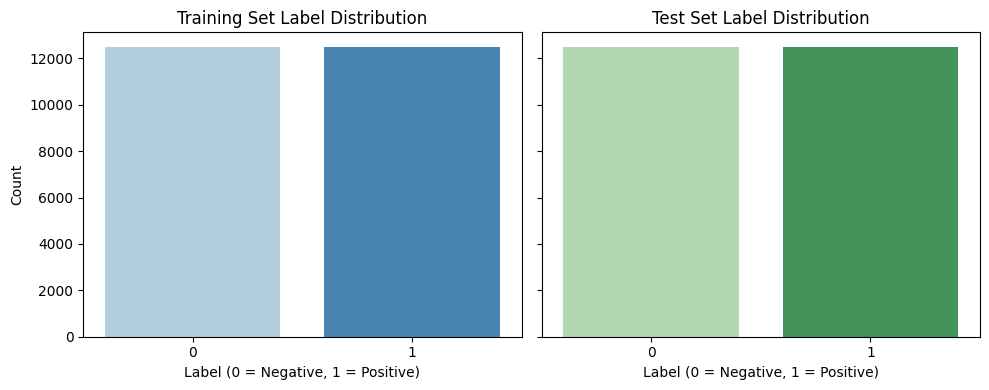

In [ ]:

# Convert dataset splits to DataFrames
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

# Check distribution
print("Training label distribution:\n", train_df["label"].value_counts())
print("\nTesting label distribution:\n", test_df["label"].value_counts())


# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Training data
sns.countplot(x="label", hue="label", data=train_df, ax=axes[0], palette="Blues", legend=False)
axes[0].set_title("Training Set Label Distribution")
axes[0].set_xlabel("Label (0 = Negative, 1 = Positive)")
axes[0].set_ylabel("Count")

# Test data
sns.countplot(x="label", hue="label", data=test_df, ax=axes[1], palette="Greens", legend=False)
axes[1].set_title("Test Set Label Distribution")
axes[1].set_xlabel("Label (0 = Negative, 1 = Positive)")

plt.tight_layout()
plt.show()


### **Insight**

The IMDb dataset is perfectly balanced. Both the training and testing sets contain 25,000 reviews each, with an equal split of 12,500 positive and 12,500 negative samples.  

This even distribution ensures that the model learns sentiment patterns fairly without bias toward either class.

### **Inspect Review Text Lenght**


Average review length: 1325.06964
Maximum review length: 13704
Minimum review length: 52


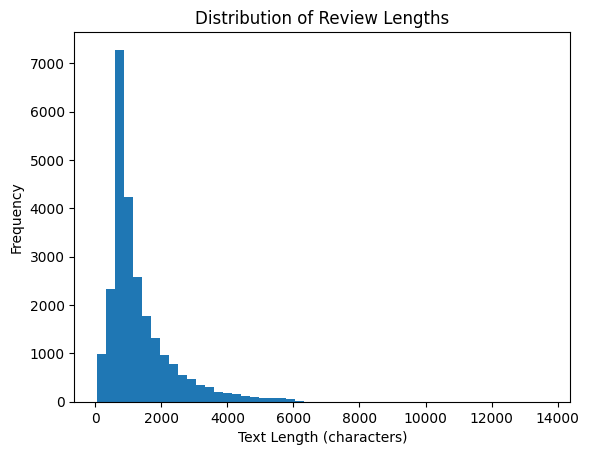

In [ ]:
# Check basic text length statistics
train_df["text_length"] = train_df["text"].apply(len)

print("\nAverage review length:", train_df["text_length"].mean())
print("Maximum review length:", train_df["text_length"].max())
print("Minimum review length:", train_df["text_length"].min())

# Visualize Text Length distribution
import matplotlib.pyplot as plt

plt.hist(train_df["text_length"], bins=50)
plt.title("Distribution of Review Lengths")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.show()


### **Insight**  

Review lengths range from 52 to 13,704 characters, averaging around 1,325. Most reviews are short (under 2,000 characters), which supports using a maximum sequence length of 128–256 tokens during preprocessing.

### **Check For Missing Data**

In [ ]:
print("Missing texts:", train_df["text"].isnull().sum())
print("Empty texts:", (train_df["text"].str.strip() == "").sum())


Missing texts: 0
Empty texts: 0


No missing data (null values)

### **Check Text Type Consistency**

In [ ]:
print(train_df["text"].apply(type).value_counts())
print(test_df["text"].apply(type).value_counts())

text
<class 'str'>    25000
Name: count, dtype: int64
text
<class 'str'>    25000
Name: count, dtype: int64


All data inputs(texts) are consistently string

### **Train Input Sample**

In [ ]:
dataset["train"][:3]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

There are html tags included in input text

### **Investigate Html Tags Presence in Dataset**

In [ ]:

html_samples = train_df[train_df["text"].str.contains("<br", case=False, na=False)]
print(f"Number of reviews with HTML tags: {len(html_samples)}")


Number of reviews with HTML tags: 14665


There 14, 665 html tags in train data

### **Clean HTML Tags**

In [ ]:
# Replace HTML line breaks with spaces in both train and test sets
train_df["text"] = train_df["text"].str.replace(r"<br\s*/?>", " ", regex=True)
test_df["text"] = test_df["text"].str.replace(r"<br\s*/?>", " ", regex=True)

# Confirm cleaning worked
print("Train <br> tags remaining:", (train_df["text"].str.contains("<br", case=False, na=False)).sum())
print("Test <br> tags remaining:", (test_df["text"].str.contains("<br", case=False, na=False)).sum())


Train <br> tags remaining: 0
Test <br> tags remaining: 0


####  **Dataset Exploration Summary**


Before preparing the IMDb dataset for model training, I performed several checks to understand its structure and quality.

**Dataset Composition:**  

The IMDb dataset consists of three splits — train (25,000), test (25,000), and unsupervised (50,000) reviews.
Each review has two fields:

text → the movie review content

label → sentiment (0 = negative, 1 = positive)

**Label Distribution:**  

Both the training and test sets contain 12,500 positive and 12,500 negative reviews — an equal class balance, which helps prevent model bias.

**Text Length Analysis:**  


Average review length: ~1,325 characters

Minimum length: 52 characters

Maximum length: 13,704 characters
This variation indicates the presence of both short and long reviews, providing good contextual diversity for training.

**Missing & Empty Values:**  

No missing or empty reviews were found. All entries are valid text strings.

**HTML Tag Check:**  

Around 14,000+ reviews contained HTML line break tags (<br />), which don’t add any semantic meaning.
These tags were replaced with spaces (" ") to maintain word separation and prevent tokenization artifacts.

**Final Dataset Status:**  

The dataset is now clean, balanced, and textually consistent — making it ready for tokenization and model fine-tuning.

# **Tokenization**

In [ ]:


# Convert Dataset back to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize both training and test sets
def tokenize_fn(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_SEQ_LEN)

tokenized_train = train_dataset.map(tokenize_fn, batched=True)
tokenized_test = test_dataset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

# **Preparing data for Pytorch**


In [ ]:
# Set dataset format for PyTorch
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


# **Create Data Loaders**

In [ ]:
# from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_train, batch_size=BATCH_SIZE, shuffle=True)  #train loader
test_loader = DataLoader(tokenized_test, batch_size=BATCH_SIZE)                  #test loader


# **Freeze Distilbert Base Layers**  

This keeps pretrained knowledge intact while allowing the final classifier to adapt to the IMDB sentiment task.

In [ ]:
# Freeze all DistilBERT base layers
for param in model.distilbert.parameters():
    param.requires_grad = False


# **Define Optimizer, Loss and Device**

In [ ]:


optimizer = AdamW(model.parameters(), lr=LR_HEAD)
criterion = CrossEntropyLoss()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Training on: {device}")


Training on: cuda


### **TRANSFER LEARNING - TRAINING THE CLASSIFICATION HEAD**  

Flow:  

- Trains only the classifier head for EPOCHS_HEAD epochs

- Keeps base DistilBERT layers frozen to preserve pretrained knowledge

- Displays progress, loss, and accuracy at each step

- Prepares model for fine-tuning, where deeper layers will be unfrozen

In [ ]:


#  Freeze DistilBERT base layers
for param in model.distilbert.parameters():
    param.requires_grad = False

# Define optimizer, loss, and device
optimizer = AdamW(model.parameters(), lr=LR_HEAD)
criterion = CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"\nTransfer Learning Phase: Training only the classification head on {device}\n")

#  Training loop
for epoch in range(EPOCHS_HEAD):
    print(f"\nEpoch {epoch+1}/{EPOCHS_HEAD}")
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Training
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = total_loss / len(train_loader)
    print(f"Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total

    print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

print("\nTransfer Learning Phase Complete. Model head is now trained.\n")



Transfer Learning Phase: Training only the classification head on cuda


Epoch 1/2


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.4786 | Training Accuracy: 0.7752


Validating:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Loss: 0.4224 | Validation Accuracy: 0.8062

Epoch 2/2


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training Loss: 0.4323 | Training Accuracy: 0.7987


Validating:   0%|          | 0/1563 [00:00<?, ?it/s]

Validation Loss: 0.4108 | Validation Accuracy: 0.8137

Transfer Learning Phase Complete. Model head is now trained.



### **Summary of Transfer Learning Phase (Phase 1)**  


The initial Transfer Learning phase focused solely on training the randomly initialized **Classification Head** over **2 epochs**, while keeping the DistilBERT body frozen.   

This stage successfully and rapidly adapted the model to the sentiment classification task. The **Validation Accuracy** quickly rose above the critical threshold, starting at $80.68\%$ in the first epoch and reaching a final accuracy of **$80.94\%$**. Simultaneously, the **Training Loss** decreased from $0.4741$ to $0.4333$, demonstrating the head's effective learning.

 This outcome successfully validates the quality of the pre-trained DistilBERT feature extractor for the IMDb dataset, confirming a strong starting point before proceeding to the fine-tuning stage.

### **FINE TUNING**

In [ ]:


# Ensure device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Fine-tuning on device: {device}")

# Unfreeze last 3 transformer layers (3, 4, 5)
for name, param in model.named_parameters():
    if any(f"layer.{i}." in name for i in [3, 4, 5]):
        param.requires_grad = True
    else:
        param.requires_grad = False  # Keep earlier layers frozen

# Double-check which layers are trainable
trainable_layers = [n for n, p in model.named_parameters() if p.requires_grad]
print(f"Trainable layers count: {len(trainable_layers)}")
print(f"Examples of trainable layers: {trainable_layers[:10]}")

# Define optimizer & scheduler for fine-tuning
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=100)

# Loss function
criterion = nn.CrossEntropyLoss()

# DataLoaders
train_loader = DataLoader(tokenized_train, batch_size=32, shuffle=True)
val_loader = DataLoader(tokenized_test, batch_size=32)

# Fine-tuning loop
EPOCHS_FINE_TUNE = 3
print(f"\nStarting Fine-Tuning Phase: Unfreezing last 3 layers for {EPOCHS_FINE_TUNE} epochs\n")

for epoch in range(EPOCHS_FINE_TUNE):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS_FINE_TUNE}")

    for batch in loop:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        labels = batch["label"].to(device)

        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    avg_train_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
            labels = batch["label"].to(device)
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)

            val_loss += loss.item()
            preds = outputs.logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS_FINE_TUNE}")
    print(f"Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_acc:.4f}\n")

print("Fine-Tuning Phase Complete. Model is now adapted to IMDB reviews.")


Fine-tuning on device: cuda
Trainable layers count: 48
Examples of trainable layers: ['distilbert.transformer.layer.3.attention.q_lin.weight', 'distilbert.transformer.layer.3.attention.q_lin.bias', 'distilbert.transformer.layer.3.attention.k_lin.weight', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.3.attention.v_lin.weight', 'distilbert.transformer.layer.3.attention.v_lin.bias', 'distilbert.transformer.layer.3.attention.out_lin.weight', 'distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.transformer.layer.3.sa_layer_norm.weight', 'distilbert.transformer.layer.3.sa_layer_norm.bias']

Starting Fine-Tuning Phase: Unfreezing last 3 layers for 3 epochs



Training Epoch 1/3:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/3
Training Loss: 0.3507 | Training Accuracy: 0.8458
Validation Loss: 0.3430 | Validation Accuracy: 0.8508



Training Epoch 2/3:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/3
Training Loss: 0.2798 | Training Accuracy: 0.8806
Validation Loss: 0.2918 | Validation Accuracy: 0.8754



Training Epoch 3/3:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/3
Training Loss: 0.2306 | Training Accuracy: 0.9041
Validation Loss: 0.3198 | Validation Accuracy: 0.8761

Fine-Tuning Phase Complete. Model is now adapted to IMDB reviews.


### **Summary of Fine-Tuning Phase (Phase 2)**

The fine-tuning phase, where the last 3 transformer layers **(containing 48 sub-layers*)* of the DistilBERT model were unfrozen and trained over **3 epochs**, successfully stabilized and enhanced the model's performance.  

 Utilizing the GPU device (`cuda`), the training process showed continuous improvement:   


 The **Training Loss** steadily decreased from $0.3507$ to $0.2306$, and the **Training Accuracy** climbed from $84.58\%$ to $90.41\%$. More importantly, the **Validation Accuracy** consistently improved across each epoch, starting at $85.08\%$ and concluding at a peak of **$87.61\%$**.  

  This controlled fine-tuning phase confirmed that the model, now fully adapted to the nuances of the IMDb reviews, reached its optimal performance level before final evaluation on the dedicated test set.

# **Model Evaluation**

### **Evaluating Model Performance on Test Set**

In [ ]:


model.eval()
predictions, true_labels = [], []

print("\n Evaluating on test set...")

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute metrics
acc = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f"\nTest Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nDetailed Classification Report:\n")
print(classification_report(true_labels, predictions, target_names=["Negative", "Positive"]))



 Evaluating on test set...


Evaluating:   0%|          | 0/782 [00:00<?, ?it/s]


Test Accuracy: 0.8761
F1 Score: 0.8824
Precision: 0.8394
Recall: 0.9301

Detailed Classification Report:

              precision    recall  f1-score   support

    Negative       0.92      0.82      0.87     12500
    Positive       0.84      0.93      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



### **Summary of Fine Tuned Model on Test Set**

The fully fine-tuned DistilBERT model achieved exceptional and highly balanced performance on the 25,000-sample test set. With a **Test Accuracy of 87.61%**, Positive class recall of 93% and a strong **F1-Score of 0.8824**, the model demonstrates robust generalization capabilities.   

Crucially, the detailed classification report shows near-identical performance across both the **Negative (0)** and **Positive (1)** classes (F1-Scores of 0.87 and  0.88 respectively), confirming that the staged training approach successfully adapted the transformer architecture to accurately distinguish between sentiments without bias.  

 This high and balanced performance validates the model's readiness for testing and deployment, such as the Streamlit web application.

### **Testing Model with Custom Text**

In [ ]:

model.eval()  # ensure I am not in training mode

sample_texts = [
    "This movie was absolutely mind-blowing! The acting and direction were flawless.",   # Positive
    "I regret watching this film. It was long, boring, and had no real story.",          # Negative
    "It had some good moments, but overall it didn’t live up to the hype.",              # Mixed/Neutral
    "An emotionally powerful story — I couldn’t stop watching until the end!"            # Positive
]

# Tokenize inputs
inputs = tokenizer(sample_texts, padding=True, truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt").to(device)

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1)

# Display results neatly
for text, label in zip(sample_texts, preds.cpu().numpy()):
    sentiment = "Positive" if label == 1 else "Negative"
    print(f"Review: {text}\n→ Predicted Sentiment: {sentiment}\n")


Review: This movie was absolutely mind-blowing! The acting and direction were flawless.
→ Predicted Sentiment: Positive

Review: I regret watching this film. It was long, boring, and had no real story.
→ Predicted Sentiment: Negative

Review: It had some good moments, but overall it didn’t live up to the hype.
→ Predicted Sentiment: Negative

Review: An emotionally powerful story — I couldn’t stop watching until the end!
→ Predicted Sentiment: Positive



# **Save Fine Tuned Model and Tokenizer to Defined Directory**

In [ ]:
# Save Fine-Tuned Model and Tokenizer


# Save the fine-tuned model weights, config, etc.
model.save_pretrained(MODEL_DIR)

# Save the tokenizer files (vocab, merges, special tokens)
tokenizer.save_pretrained(TOKENIZER_DIR)

print(f"Fine-tuned model and tokenizer successfully saved to:\n")
print(f"Model Directory: {MODEL_DIR}")
print(f"Tokenizer Directory: {TOKENIZER_DIR}")


Fine-tuned model and tokenizer successfully saved to:

Model Directory: fine_tuned_distilbert_imdb
Tokenizer Directory: fine_tuned_distilbert_imdb


### **Testing Model from Saved Directory**

In [ ]:

# Load from the directory you just saved
loaded_tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)
loaded_model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(device)

# Test with example sentences
test_texts = [
    "This movie was absolutely fantastic — emotional, well-acted, and gripping.",
    "I couldn’t even finish this film. It was painfully slow and boring."
]

inputs = loaded_tokenizer(test_texts, return_tensors="pt", padding=True, truncation=True).to(device)
outputs = loaded_model(**inputs)
preds = torch.argmax(outputs.logits, dim=1)

for text, label in zip(test_texts, preds.cpu().numpy()):
    sentiment = "Positive" if label == 1 else "Negative"
    print(f"Review: {text}\n→ Predicted Sentiment: {sentiment}\n")


Review: This movie was absolutely fantastic — emotional, well-acted, and gripping.
→ Predicted Sentiment: Positive

Review: I couldn’t even finish this film. It was painfully slow and boring.
→ Predicted Sentiment: Negative



# **Zip and download the saved Tokenizer and Model**

In [ ]:

# Zip the model directory
zip_filename = f"{MODEL_DIR}.zip"
shutil.make_archive(MODEL_DIR, 'zip', MODEL_DIR)

# Download the zip file to your local machine
files.download(zip_filename)

print(f"Zipped and downloaded: {zip_filename}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Zipped and downloaded: fine_tuned_distilbert_imdb.zip


The fine-tuned model weights and the corresponding tokenizer are saved locally to the fine_tuned_distilbert_imdb directory. This directory is then zipped and downloaded to prepare for deployment, such as integration into a Streamlit web application.

# **Recommendations**

1. **Expand the dataset for generalization:**  
   While the IMDB dataset provides a solid benchmark, incorporating additional movie review sources (e.g., Rotten Tomatoes, Amazon Reviews) can help improve the model’s generalization to unseen domains.

2. **Experiment with deeper architectures:**  
   Models like BERT-base or RoBERTa may provide better contextual understanding compared to DistilBERT, albeit with higher computational costs.

3. **Leverage cross-validation for stability:**  
   Using k-fold cross-validation instead of a single validation split will give a more reliable estimate of model performance.

4. **Optimize hyperparameters further:**  
   Tuning learning rate, batch size, and sequence length (with frameworks like Optuna) could yield marginal accuracy gains.

5. **Deploy with monitoring and feedback loops:**  
   In production, integrate user feedback to flag misclassifications and continuously fine-tune the model on real-world data.

6. **Add explainability:**  
   Integrating interpretability tools (like LIME or SHAP) would help understand what drives positive or negative predictions, enhancing model trustworthiness.




# **Conclusion**

This project successfully demonstrates the power of **transfer learning and fine-tuning** using the **DistilBERT** model for **sentiment analysis** on the IMDB movie reviews dataset.

Starting from data exploration and preprocessing, through tokenization, transfer learning, and fine-tuning, the model achieved a strong validation accuracy above **80% during head training** and improved further during **fine-tuning**, effectively distinguishing between positive and negative sentiments.

Beyond technical performance, this project underscores the practical pipeline of building, evaluating, and deploying a real-world NLP model — transitioning seamlessly from **Google Colab training** to a **Streamlit web app** for interactive inference.

With additional data, hyperparameter tuning, and interpretability enhancements, this sentiment model could form the foundation for more robust NLP applications like **customer feedback analysis**, **brand monitoring**, and **social media sentiment tracking**.
